In [1]:
import os
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
from datetime import datetime
import matplotlib.pyplot as plt
from time_series.preprocessing.generate_dataset import Offsets
from time_series.preprocessing.generate_dataset import MakeDatasetFromDataFrame
from time_series.tensorflow.wrappers import compile_and_fit
from time_series.tensorflow.wrappers import apply_model
from time_series.plotting.plot_time_series import plot_time_series
from tensorflow.keras import Sequential
from time_series.tensorflow.analyse import plot_training


%load_ext autoreload
%autoreload 2

In [2]:
from time_series.sources.weather import get_weather_data
df = get_weather_data()

array([<AxesSubplot:xlabel='Date Time'>, <AxesSubplot:xlabel='Date Time'>,
       <AxesSubplot:xlabel='Date Time'>, <AxesSubplot:xlabel='Date Time'>,
       <AxesSubplot:xlabel='Date Time'>, <AxesSubplot:xlabel='Date Time'>,
       <AxesSubplot:xlabel='Date Time'>, <AxesSubplot:xlabel='Date Time'>,
       <AxesSubplot:xlabel='Date Time'>, <AxesSubplot:xlabel='Date Time'>,
       <AxesSubplot:xlabel='Date Time'>, <AxesSubplot:xlabel='Date Time'>,
       <AxesSubplot:xlabel='Date Time'>, <AxesSubplot:xlabel='Date Time'>],
      dtype=object)

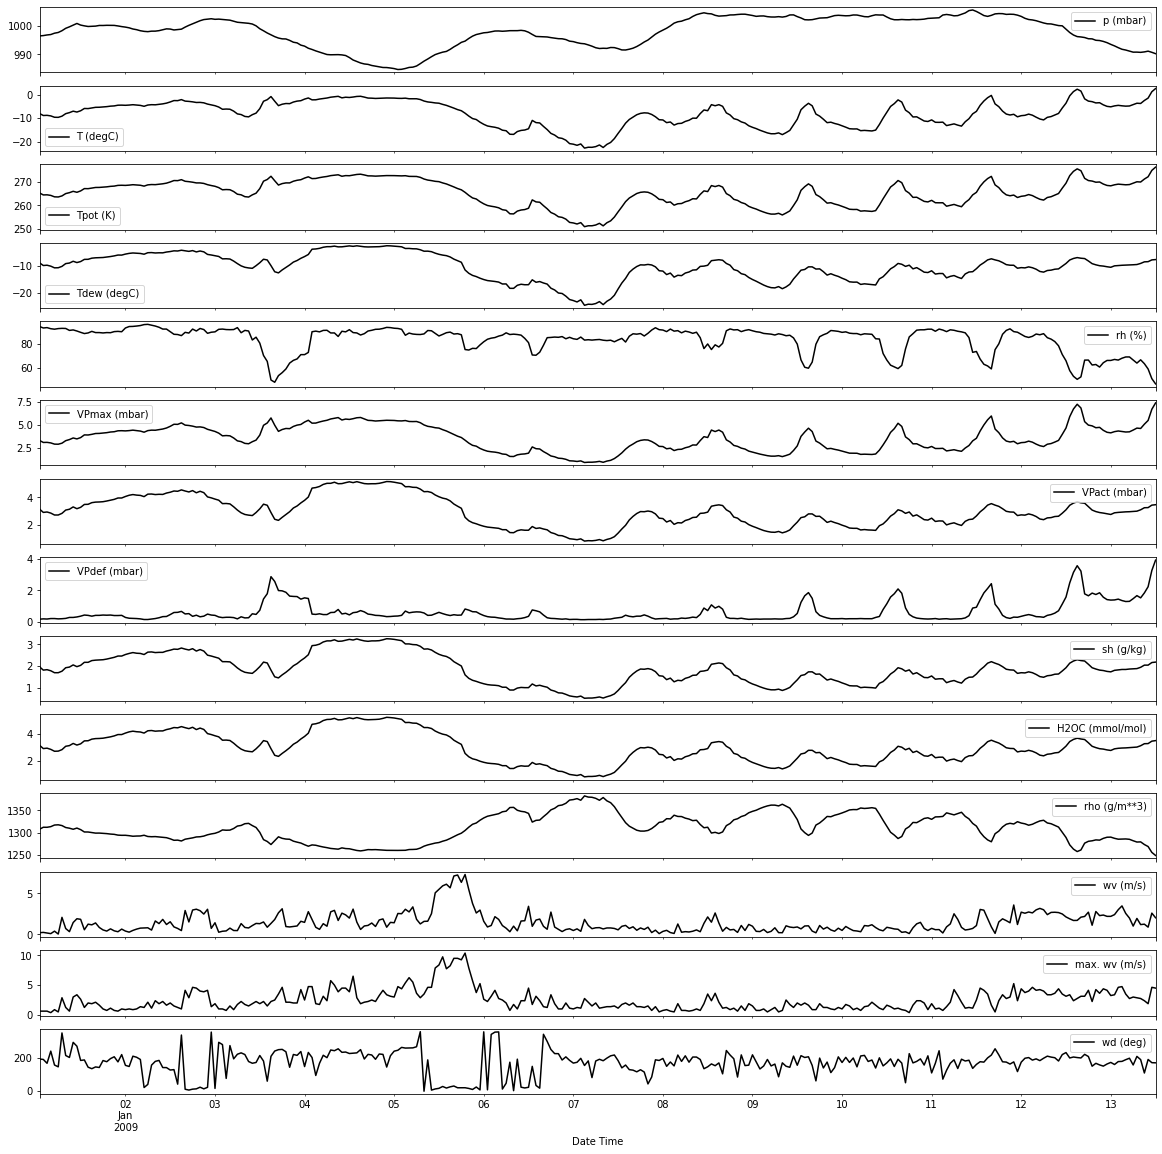

In [3]:
df[:300].plot(subplots=True, color="black", figsize=(20,20))

In [4]:
df.describe()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
count,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000
mean,989.212842,9.450482,283.493086,4.956471,76.009788,13.576576,9.533968,4.042536,6.022560,9.640437,1216.061232,1.702567,2.963041,174.789095
std,8.358886,8.423384,8.504424,6.730081,16.474920,7.739883,4.183658,4.898549,2.655812,4.234862,39.974263,65.447512,75.597657,86.619431
min,913.600000,-22.760000,250.850000,-24.800000,13.880000,0.970000,0.810000,0.000000,0.510000,0.810000,1059.450000,-9999.000000,-9999.000000,0.000000
25%,984.200000,3.350000,277.440000,0.240000,65.210000,7.770000,6.220000,0.870000,3.920000,6.290000,1187.470000,0.990000,1.760000,125.300000
50%,989.570000,9.410000,283.460000,5.210000,79.300000,11.820000,8.860000,2.190000,5.590000,8.960000,1213.800000,1.760000,2.980000,198.100000
75%,994.720000,15.480000,289.530000,10.080000,89.400000,17.610000,12.360000,5.300000,7.800000,12.490000,1242.765000,2.860000,4.740000,234.000000
max,1015.290000,37.280000,311.210000,23.060000,100.000000,63.770000,28.250000,46.010000,18.070000,28.740000,1393.540000,14.010000,23.500000,360.000000


### Impute values
- Wind velocities shall be positive. 
- So we interpret the value -9999 as missing value and impute it by 0

In [5]:
from pandas import DataFrame
def impute_wind_velocities(df: DataFrame):
    cols = ['wv (m/s)', 'max. wv (m/s)']
    for col in cols:
        mask = df[col] == -9999
        df[col][mask] = 0.0
    return df

In [6]:
df = impute_wind_velocities(df)
df.describe()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
count,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000
mean,989.212842,9.450482,283.493086,4.956471,76.009788,13.576576,9.533968,4.042536,6.022560,9.640437,1216.061232,2.130539,3.533671,174.789095
std,8.358886,8.423384,8.504424,6.730081,16.474920,7.739883,4.183658,4.898549,2.655812,4.234862,39.974263,1.543098,2.343417,86.619431
min,913.600000,-22.760000,250.850000,-24.800000,13.880000,0.970000,0.810000,0.000000,0.510000,0.810000,1059.450000,0.000000,0.000000,0.000000
25%,984.200000,3.350000,277.440000,0.240000,65.210000,7.770000,6.220000,0.870000,3.920000,6.290000,1187.470000,0.990000,1.760000,125.300000
50%,989.570000,9.410000,283.460000,5.210000,79.300000,11.820000,8.860000,2.190000,5.590000,8.960000,1213.800000,1.760000,2.980000,198.100000
75%,994.720000,15.480000,289.530000,10.080000,89.400000,17.610000,12.360000,5.300000,7.800000,12.490000,1242.765000,2.860000,4.740000,234.000000
max,1015.290000,37.280000,311.210000,23.060000,100.000000,63.770000,28.250000,46.010000,18.070000,28.740000,1393.540000,14.010000,23.500000,360.000000


###  Detecting periodicity
- This can be done in a systematic way by a fourier analysis. 

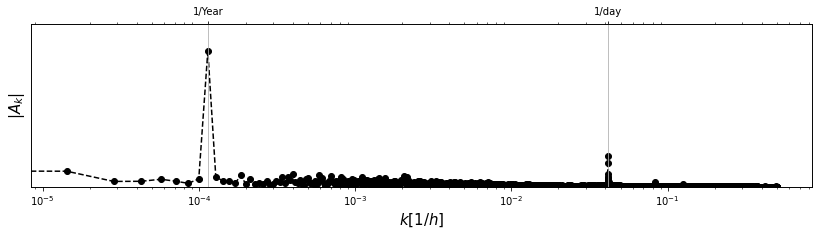

In [7]:
from dataclasses import dataclass
from pandas import Series
from numpy import ndarray

@dataclass
class DFT:
    abs_fourier: float
    frequencies: str



def abs_discrete_fourier(ys: ndarray): 
    N = ys.size
    abs_fourier = tf.abs(tf.signal.rfft(ys))
    frequencies = np.fft.fftfreq(ys.size, d=1)[:N//2+1]
    return DFT(abs_fourier=abs_fourier, frequencies=frequencies)

    
def plot_spectrum(dft: DFT):
    fig, ax = plt.subplots(figsize=(14,3))
    ax.plot(dft.frequencies, dft.abs_fourier,  "--o", color="black")
    ax.set_xscale("log")
    ax.set_xlabel("$k[1/h]$", fontsize=15)
    ax.set_ylabel(r"$\vert A_k\vert$", fontsize=15)
    ax.set_ylim(0,400000)
    ax.set_yticks([])
    # add 1/year and 1/day frequency in hours for visual comparision
    ax2 = ax.twiny()
    ax2.set_xlim(ax.get_xlim())
    ax2.set_xscale("log")
    ax2.set_xticks([1/(24*365.2524), 1/24.])
    ax2.set_xticklabels(['1/Year', '1/day'])
    ax2.grid([1/(24*365.2524), 1/24.])
    
dft = abs_discrete_fourier(df['T (degC)'])
plot_spectrum(dft)

### Dealing with periodicity

**Temporal periodicty.**
- We have just inspected this. 
**Spacial periodiciy.**
- But we also have spacial periodicity. This comes from the wind direction.  

# Data preparation
- Split train, validation, and test data
- Normalize data

In [8]:
@dataclass
class Data:
    train: DataFrame
    validation: DataFrame
    test: DataFrame
    column_indices: dict
        
    def map(self, f): 
        return Data(f(self.train), f(self.validation), f(self.test), self.column_indices)
    
    def on_train(self, f):
        return Data(f(self.train), self.validation, self.test, self.column_indices)
    
    def on_validation_and_test(self, f):
        return Data(self.train, f(self.validation), f(self.test), self.column_indices)
    
    def normalize(self):
        mean = self.train.mean()
        std = self.train.std()
        f = lambda df: (df - mean) / std 
        return self.map(f)
    
        

def split_data(df: DataFrame):
    column_indices = {name: i for i, name in enumerate(df.columns)}
    num_features = df.shape[1]    
    n = len(df)
    return Data(train=df[0:int(n*0.7)], 
                validation=df[int(n*0.7):int(n*0.9)],
                test=df[int(n*0.9):],
                column_indices=column_indices)

### Prepare dataset of time windows

In [9]:
def make_dataset(offsets, shuffle_buffer_size=None): 
    """For later convenience pre-parametrize this class"""
    return MakeDatasetFromDataFrame(offsets=offsets, 
                                    batch_size=32, 
                                    labels=["T (degC)"], 
                                    shuffle_buffer_size=shuffle_buffer_size)

data = split_data(df).normalize()

### Plotting helpers

In [10]:
def plot_overall_time_series(data: DataFrame,
                             ds, 
                             offsets,  
                             model=None, 
                             x_lim = (datetime(2016, 5, 1), datetime(2016, 5, 2))):
    x_range = data.index[offsets.input_width:] # omitt label width
    plot_time_series(x_range, *apply_model(model, ds), "T scaled", 
                     x_lim=x_lim, 
                     style="o-")

class PlotSingleTimeSeries:
    def __init__(self, offsets, input_column_index,   model=None):
        self.offsets = offsets
        self.input_column_index = input_column_index
        self.model = model
        
                
    def __call__(self, iterator):
        data = iterator.get_next()
        x_input = data[0]
        y_true = data[1]
        y_predicted = None
        if self.model:
            y_predicted = self.model.predict(x_input).flatten()
        self.plot(x_input.numpy()[:, :, self.input_column_index].flatten(), y_true.numpy().flatten(), y_predicted)
        
        
    def from_dataset(self, ds): 
        """Plot single element ds"""
        x_input = self._to_tensor(ds, lambda x, y: x)[:, self.input_column_index].flatten()
        y_true = self._to_tensor(ds, lambda x, y: y).flatten()
        y_predicted = None
        if self.model:
            y_predicted = self.model.predict(ds).flatten()
        self.plot(x_input, y_true, y_predicted)

    
    def plot(self, x_input, y_true, y_predicted):
        """Plots singel time series as specified by offsets"""
       
        times_features = np.arange(offsets.input_width)
        start = self.offsets.input_width + self.offsets.shift - self.offsets.label_width 
        end = start + offsets.label_width
        times_forecast = np.arange(start, end)
        fix, ax = plt.subplots(figsize=(15,3))
        ax.plot(times_features, x_input, "-o", color="black", ms=10, label="Input")
        ax.plot(times_forecast, y_true, "-o", color="black", ms=10, mfc="white", label="Truth")
        if self.model: 
            ax.plot(times_forecast, y_predicted, "-o", color="red", ms=10,  label="Forecast")
        ax.legend()
        ax.set_xticks(np.arange(0, end))
        
    def _to_tensor(self, ds, f: callable):
        return tf.concat([batch for batch in ds.map(f)], axis=0).numpy()
    
    
def get_iterator(ds):
    return iter(ds.unbatch().map(lambda x, y: (tf.expand_dims(x, 0), y)))

# One step ahead models

In [11]:
# parametrize data
offsets = Offsets(input_width=1, label_width=1)
# make dataset with this parametrization - no shuffling for validation and training set.

ds = (data.on_train(make_dataset(offsets, 100000))
          .on_validation_and_test(make_dataset(offsets, None)))

# check shapes    
for x, y in ds.train.take(1):
    print(x.shape)
    print(y.shape)

(32, 1, 14)
(32, 1, 1)


### Linear Models

In [12]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=2, mode='min')
optimizer = tf.optimizers.Adam()
mae = tf.metrics.MeanAbsoluteError()

def wrap_training(model, train, validation):
    """Keep the code shorter lateron"""
    return compile_and_fit(model, 
                           train, 
                           validation, 
                           epochs=20, 
                           optimizer=optimizer, 
                           callbacks=[early_stopping])

In [13]:
# todo explain this model architecture in more detail.
model = Sequential([tf.keras.Input(shape=(1, 14)), # (time, feature) 
                    tf.keras.layers.Dense(units=1)])

history = wrap_training(model, ds.train, ds.validation)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1, 1)              15        
Total params: 15
Trainable params: 15
Non-trainable params: 0
_________________________________________________________________
None


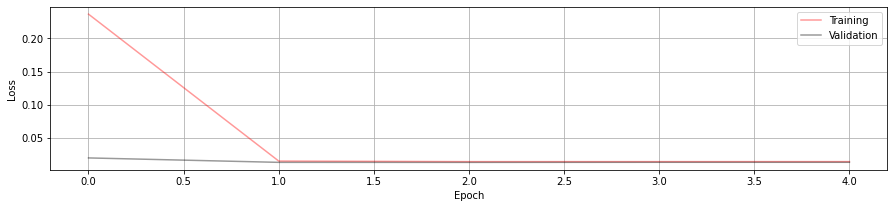

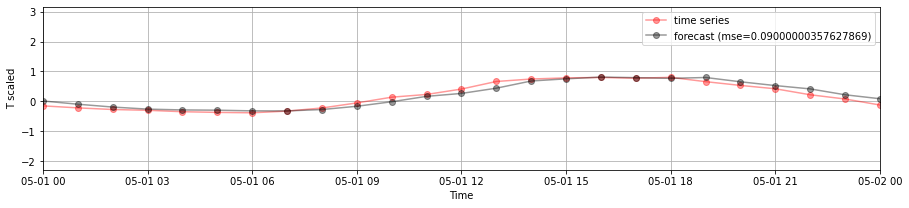

In [14]:
iterator = get_iterator(ds.test)
single_time_series_plotter = PlotSingleTimeSeries(offsets, input_column_index=ds.column_indices["T (degC)"], model=model)
plot_training(history)
plot_overall_time_series(data.test, ds.test, offsets, model)

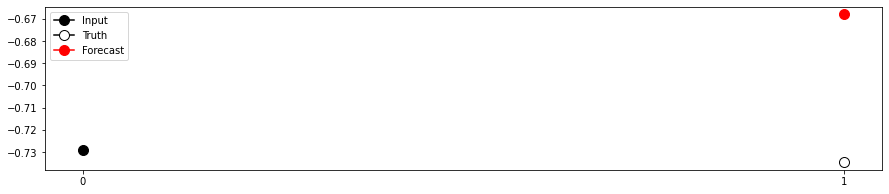

In [15]:
single_time_series_plotter(iterator)

### Multi step models
- So far we have only used one point in time to predict the next one
- Now, we would like to add some "context". 
- That is we want to allow the model to learn the temporal behavior from the past.
- So, we add more past time steps to the data.
- Also we need a `Flatten()` Layer.
- Still, we stick to a dense network architecture (we will address this lateron).
- The down-side of such a DNN approach is:
    - The resulting model can only be executed on input windows with the definied time-shape
    - As a consequence very long time windows yield too many parameters to fit.
    - RNNs or 1D-CNNs solve this problems

In [35]:
offsets = Offsets(input_width=3, label_width=1)

ds = (data.on_train(make_dataset(offsets, 100000))
          .on_validation_and_test(make_dataset(offsets, None)))

model = Sequential([tf.keras.Input(shape=(3, 14)), # (time, feature) 
                    tf.keras.layers.Flatten(),
                    tf.keras.layers.Dense(units=32, activation='relu'),
                    tf.keras.layers.Dense(units=1)])

history = wrap_training(model, ds.train, ds.validation)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 42)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1376      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 1,409
Trainable params: 1,409
Non-trainable params: 0
_________________________________________________________________
None


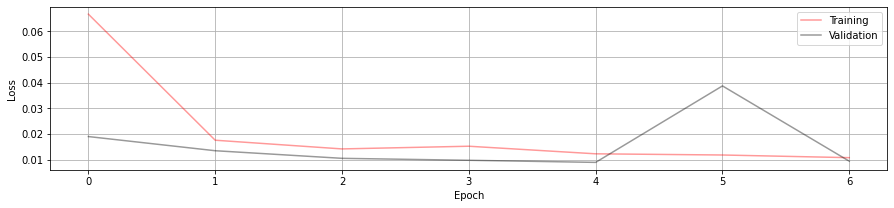

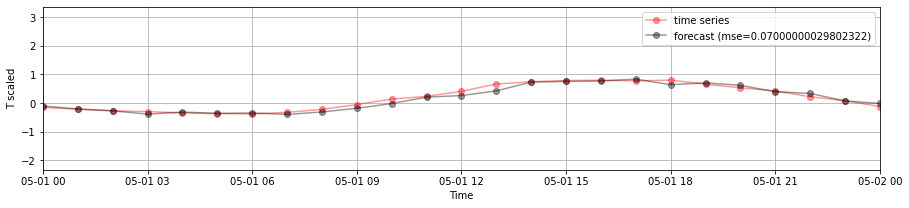

In [38]:
iterator = get_iterator(ds.test)
single_time_series_plotter = PlotSingleTimeSeries(offsets, input_column_index=1, model=model)
plot_training(history)
plot_overall_time_series(data.test, ds.test, offsets, model)

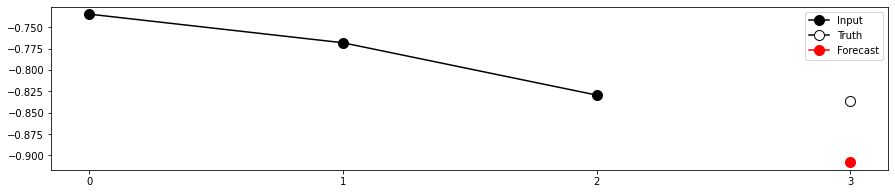

In [40]:
single_time_series_plotter(iterator)

### 1D Convolutional Neural Network

In [45]:
model = Sequential([
         tf.keras.Input(shape=(None, 14)),
         tf.keras.layers.Conv1D(filters=32,
                                kernel_size=(3,),
                                activation='relu'),
         tf.keras.layers.Dense(units=32, activation='relu'),
         tf.keras.layers.Dense(units=1)])

history = compile_and_fit(model, ds.train, ds.validation)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, None, 32)          1376      
_________________________________________________________________
dense_11 (Dense)             (None, None, 32)          1056      
_________________________________________________________________
dense_12 (Dense)             (None, None, 1)           33        
Total params: 2,465
Trainable params: 2,465
Non-trainable params: 0
_________________________________________________________________
None


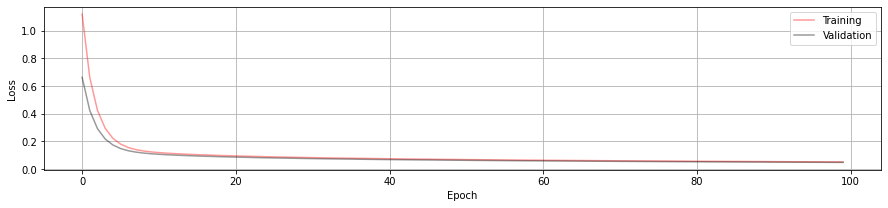

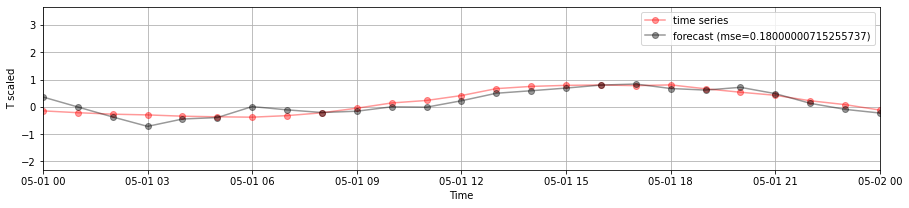

In [46]:
iterator = get_iterator(ds.test)
single_time_series_plotter = PlotSingleTimeSeries(offsets, input_column_index=1, model=model)
plot_training(history)
plot_overall_time_series(data.test, ds.test, offsets, model)

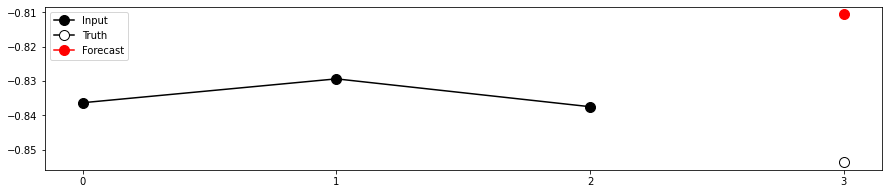

In [51]:
single_time_series_plotter(iterator)

### Implementing (baseline) models in tensorflow 
- Naive Method via the keras API

In [20]:
class NaiveMethod(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__(autocast = False)
        self.label_index = label_index
        

    def call(self, inputs):
        """Only works if input width and label width are the same"""
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [33]:
# Re-parametrize input data prediction is only bases on previous timestep
# The implementation also works "vectorized", i.e., as long as input_width=label_width. 
# But the model really takes one timestep in the past and predicts the next one. 
# So let's stick to this case
offsets = Offsets(input_width=1, label_width=1)

ds = (data.on_train(make_dataset(offsets, 100000))
          .on_validation_and_test(make_dataset(offsets, None)))

model = NaiveMethod(ds.column_indices["T (degC)"])
model.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])
model.evaluate(ds.validation)
model.evaluate(ds.test)

220/220 [==============================] - 1s 3ms/step - loss: 0.0142 - mean_absolute_error: 0.0852


[0.014162620529532433, 0.08516010642051697]

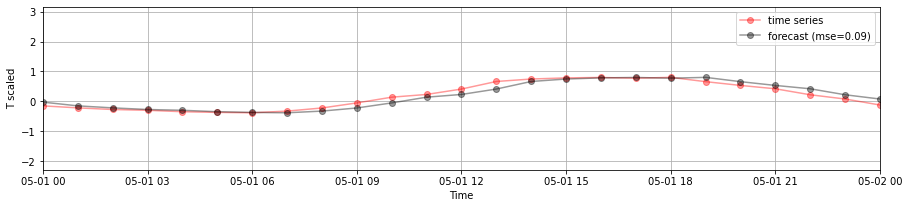

In [34]:
plot_overall_time_series(data.test, ds.test, offsets, model)